# Basic Simulation Sample

This notebook contains an implementation of a very simple world simulation built with Neighborly. It demonstrates how to author content starting with the settlement definition and ending with characters.

## Instantiate the simulation

We start by creating a new simulation instance. We can supply a seed value to the configuration to
have the simulation reproduce a similar world. Feel free to uncomment the seed value and try different seeds. If no seed is provided, a random integer seed is generated by the system.This feature is the same as what can be found in Minecraft. Also, we supply a single string for the `settlement` property. This is the ID of the settlement definition to use when generating the world. We create a settlement definition in the next step. Finally, we configure the logging options for the simulation. Currently, it will print out all the world's events as they happen.

In [1]:
from neighborly.simulation import Simulation
from neighborly.config import SimulationConfig, LoggingConfig
from neighborly.plugins import (
    default_events,
    default_character_names,
    default_settlement_names,
    default_traits
)

sim = Simulation(
    SimulationConfig(
        #seed=SimPLeCiTySeEd2023,
        settlement="simple_city",
        logging=LoggingConfig(logging_enabled=False),
    )
)

default_character_names.load_plugin(sim)
default_settlement_names.load_plugin(sim)
default_traits.load_plugin(sim)
default_events.load_plugin(sim)


## Creating Settlements and Districts

Neighborly represents a settlement as a collection of districts, where each district defines what types of businesses, residential buildings, and residents spawn there. Below, we create a single settlement definition and multiple district definitions. One could also define these using external JSON files and load those files into the simulation using the various helper functions found in `neighborly.loaders`.

Settlements spawn districts and districts spawn everything else. Here we have define a single district that can hold a max of three businesses and residential buildings, each. Also, we have provided a single definition ID for each type (residence, business, or character) that can spawn within the district.

In [2]:
from neighborly.defs.defaults import DefaultSettlementDef, DefaultDistrictDef
from neighborly.helpers.settlement import register_district_def, register_settlement_def


# Register our sample settlement definition
register_settlement_def(
    sim.world,
    DefaultSettlementDef(
        definition_id="simple_city",
        display_name="Simple City",
        districts=[
            "main"
        ]
    )
)

# Register a district type
register_district_def(
    sim.world,
    DefaultDistrictDef(
        definition_id="main",
        display_name="Main",
        business_slots=3,
        residential_slots=10,
        residence_types=[
            {
                "definition_id": "house"
            },
            {
                "definition_id": "apartment_building"
            }
        ],
        business_types=[
            {
                "definition_id": "office"
            },
        ],
        character_types=[
            {
                "definition_id": "person"
            }
        ]
    )
)


## Defining residence types

Each residence definition contains parameters for spawning a residential building. These buildings 
contain one or more residential units where individual families live. This representation allows
us to model single and multifamily housing. The type of housing that spawns a district has a direct
affect on the maximum population that the settlement supports. Larger housing means that more people
can spawn into the settlement.

In [3]:
from neighborly.defs.defaults import DefaultResidenceDef
from neighborly.helpers.residence import register_residence_def

register_residence_def(
    sim.world,
    DefaultResidenceDef(
        definition_id="house",
        display_name="House",
        residential_units=1,
        required_population=0,
    )
)

register_residence_def(
    sim.world,
    DefaultResidenceDef(
        definition_id="apartment_building",
        display_name="Apartment Building",
        residential_units=4,
        required_population=0,
    )
)


## Defining businesses and job

Next, lets define the business type that will spawn in the district defined above. Also, we will
define job roles for characters who work at the business.

In [4]:
from neighborly.defs.defaults import DefaultBusinessDef, DefaultJobRoleDef
from neighborly.helpers.business import register_business_def, register_job_role_def

register_business_def(
    sim.world,
    DefaultBusinessDef(
        definition_id="office",
        display_name="Office Building",
        owner_role="ceo",
        employee_roles= {
            "manager": 1,
            "pencil_pusher": 2,
            "intern": 1
        }
    )
)

register_job_role_def(
    sim.world,
    DefaultJobRoleDef(
        definition_id="ceo",
        display_name="CEO",
        job_level=5,
    )
)

register_job_role_def(
    sim.world,
    DefaultJobRoleDef(
        definition_id="manager",
        display_name="Manager",
        job_level=3,
    )
)

register_job_role_def(
    sim.world,
    DefaultJobRoleDef(
        definition_id="pencil_pusher",
        display_name="Pencil Pusher",
        job_level=2,
    )
)

register_job_role_def(
    sim.world,
    DefaultJobRoleDef(
        definition_id="intern",
        display_name="Intern",
        job_level=1,
    )
)


## Defining character types

Finally we will provide a definition used to generate new residents that spawn into the settlement.
The definition only handles spawning new residents. For example, someone can define multiple
character types that all have the same species, but different initial configuration parameters
for the types of skills, traits, and stats they are spawned with. Here we stick to a simple person
definition.

Character names are handled by the simulation's Tracery instance. [Tracery](https://tracery.io) is a
procedural text tool developed by Kate Compton. Character names should ne loaded in using Tracery
grammar files. Here we load them directly using a python dict. Names are divided into groups by
masculine, feminine, and last names.

In [5]:
from neighborly.defs.defaults import DefaultCharacterDef, DefaultSpeciesDef
from neighborly.helpers.character import register_character_def
from neighborly.helpers.traits import register_trait_def

register_character_def(
    sim.world,
    DefaultCharacterDef(
        definition_id="person",
        species=["human"]
    )
)

register_trait_def(
    sim.world,
    DefaultSpeciesDef(
        definition_id="human",
        display_name="Human",
        description="A plain ol' human being.",
        adolescent_age=13,
        young_adult_age=20,
        adult_age=30,
        senior_age=65,
        lifespan=80,
        can_physically_age=True,
    )
)


# Add new life events

Below we define two new `LifeEvent` subtypes that can occur in character's lives. `JobPromotion` simulates a character being promoted from their current job role to a higher job role at the same business. `FiredFromJob` simulated a character being fired from their job at a business. 

Each time step, the simulation loops through all the characters attempting to select one event to fire with the character as the subject of the event. `LifeEvent` subtypes are responsible for defining an `instantiate` classmethod and `event_considerations` that modifiy the base probability of the event occuring. The `LifeEventSystem` selects lefe events based on successful event instantiation and the probability of that specific instance occurring.

In cases where there are multiple ways that an event can happen. For instance, when characters select who to ask out on a date, the `instantiate` method should handle selecting who to ask out. 

In [6]:
from __future__ import annotations

import random
from typing import Any

from neighborly.datetime import SimDate
from neighborly.life_event import LifeEvent, event_consideration, EventRole
from neighborly.components.business import Occupation, Business, JobRole
from neighborly.events.defaults import LeaveJob
from neighborly.loaders import register_life_event_type
from neighborly.ecs import GameObject
from neighborly.helpers.stats import get_stat
from neighborly.helpers.relationship import get_relationship


class JobPromotion(LifeEvent):
    """The character is promoted at their job from a lower role to a higher role."""

    base_probability = 0.5 # <-- The probability of the event without considerations

    def __init__(
        self,
        subject: GameObject,
        business: GameObject,
        old_role: GameObject,
        new_role: GameObject,
    ) -> None:
        super().__init__(
            world=subject.world,
            roles=(
                EventRole("subject", subject, True),
                EventRole("business", business),
                EventRole("old_role", old_role),
                EventRole("new_role", new_role),
            ),
        )

    @staticmethod
    @event_consideration
    def relationship_with_owner(event: LifeEvent) -> float:
        """Considers the subject's reputation with the business' owner."""
        subject = event.roles["subject"]
        business_owner = event.roles["business"].get_component(Business).owner

        if business_owner is not None:
            return get_stat(
                get_relationship(business_owner, subject),
                "reputation",
            ).normalized

        return -1

    @staticmethod
    @event_consideration
    def boldness_consideration(event: LifeEvent) -> float:
        """Considers the subject's boldness stat."""
        return get_stat(event.roles["subject"], "boldness").normalized

    @staticmethod
    @event_consideration
    def reliability_consideration(event: LifeEvent) -> float:
        """Considers the subjects reliability stat."""
        return get_stat(event.roles["subject"], "reliability").normalized


    def execute(self) -> None:
        character = self.roles["subject"]
        business = self.roles["business"]
        new_role = self.roles["new_role"]

        business_data = business.get_component(Business)

        # Remove the old occupation
        character.remove_component(Occupation)

        business_data.remove_employee(character)

        # Add the new occupation
        character.add_component(
            Occupation(
                business=business,
                start_date=self.world.resource_manager.get_resource(SimDate),
                job_role=new_role.get_component(JobRole),
            )
        )

        business_data.add_employee(character, new_role.get_component(JobRole))



    @classmethod
    def instantiate(cls, subject: GameObject, **kwargs: Any) -> LifeEvent | None:
        rng = subject.world.resource_manager.get_resource(random.Random)

        if subject.has_component(Occupation) is False:
            return None

        occupation = subject.get_component(Occupation)
        current_job_level = occupation.job_role.job_level
        business_data = occupation.business.get_component(Business)
        open_positions = business_data.get_open_positions()

        higher_positions = [
            role
            for role in open_positions
            if (
                role.job_level > current_job_level
                and role.check_requirements(subject)
            )
        ]

        if len(higher_positions) == 0:
            return None

        # Get the simulation's random number generator
        rng = subject.world.resource_manager.get_resource(random.Random)

        chosen_role = rng.choice(higher_positions)

        return JobPromotion(
            subject=subject,
            business=business_data.gameobject,
            old_role=occupation.job_role.gameobject,
            new_role=chosen_role.gameobject
        )


    def __str__(self) -> str:
        subject = self.roles["subject"]
        business = self.roles["business"]
        old_role = self.roles["old_role"]
        new_role = self.roles["new_role"]

        return (
            f"{subject.name} was promoted from {old_role.name} to "
            f"{new_role.name} at {business.name}."
        )



class FiredFromJob(LifeEvent):
    """The character is fired from their job."""

    base_probability = 0.5

    def __init__(
        self, subject: GameObject, business: GameObject, job_role: GameObject
    ) -> None:
        super().__init__(
            world=subject.world,
            roles=(
                EventRole("subject", subject, True),
                EventRole("business", business),
                EventRole("job_role", job_role),
            ),
        )

    @staticmethod
    @event_consideration
    def relationship_with_owner(event: LifeEvent) -> float:
        """Considers the subject's reputation with the business' owner."""
        subject = event.roles["subject"]
        business_owner = event.roles["business"].get_component(Business).owner

        if business_owner is not None:
            return 1 - get_stat(
                get_relationship(business_owner, subject),
                "reputation",
            ).normalized

        return -1

    @staticmethod
    @event_consideration
    def reliability_consideration(event: LifeEvent) -> float:
        """Considers the subjects reliability stat."""
        return 1 - get_stat(event.roles["subject"], "reliability").normalized

    def execute(self) -> None:
        subject = self.roles["subject"]
        business = self.roles["business"]
        job_role = self.roles["job_role"]

        # Events can dispatch other events
        LeaveJob(subject=subject, business=business, job_role=job_role, reason="fired").dispatch()

        business_data = business.get_component(Business)

        owner = business_data.owner
        if owner is not None:
            get_stat(get_relationship(subject, owner), "reputation").base_value -= 20
            get_stat(get_relationship(owner, subject), "reputation").base_value -= 10


    @classmethod
    def instantiate(cls, subject: GameObject, **kwargs: Any) -> LifeEvent | None:
        if subject.has_component(Occupation) is False:
            return None

        occupation = subject.get_component(Occupation)

        return FiredFromJob(
            subject=subject,
            business=occupation.business,
            job_role=occupation.job_role.gameobject,
        )

    def __str__(self) -> str:
        subject = self.roles["subject"]
        business = self.roles["business"]
        job_role = self.roles["job_role"]

        return (
            f"{subject.name} was fired from their role as a "
            f"{job_role.name} at {business.name}."
        )



# Add the events to the simulation
register_life_event_type(sim, JobPromotion)
register_life_event_type(sim, FiredFromJob)


## Add system to track the population

Below is an example of how to create a system the collects data from the simulation while the
simulation is actively running. All the data it collects will be available within the `DataTables`
resource.

In [7]:
from neighborly.ecs import System, World
from neighborly.components.settlement import Settlement
from neighborly.data_collection import DataCollectionSystems, DataTables
from neighborly.datetime import SimDate

class TrackPopulationSystem(System):
    def on_add(self, world: World) -> None:
        world.resource_manager.get_resource(DataTables).create_table(
            "population", ("guid", "month", "year", "population")
        )

    def on_update(self, world: World) -> None:
        current_date = world.resource_manager.get_resource(SimDate)
        data_tables = world.resource_manager.get_resource(DataTables)

        for _, (settlement,) in world.get_components((Settlement,)):
            data_tables.add_data_row(
                "population",
                {
                    "guid": settlement.gameobject.uid,
                    "month": current_date.month,
                    "year": current_date.year,
                    "population": settlement.population,
                },
            )

sim.world.system_manager.add_system(
    TrackPopulationSystem(), system_group=DataCollectionSystems
)


## Run the simulation!

Now we have enough information to run the simulation.

The simulation steps in single month increments. So, every 12 timesteps equates to a one year of
in-simulation time.

In [8]:
from tqdm import tqdm

YEARS_TO_SIMULATE = 50

for _ in tqdm(range(YEARS_TO_SIMULATE * 12), ncols=100):
    sim.step()


100%|█████████████████████████████████████████████████████████████| 600/600 [00:11<00:00, 52.12it/s]


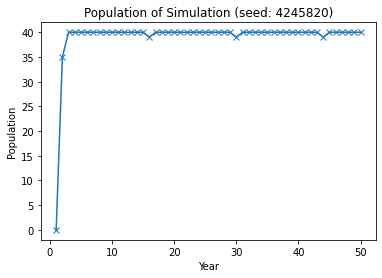

In [21]:
from neighborly.data_collection import DataTables
import matplotlib.pyplot as plt

import polars as pl

%matplotlib inline

data_tables = sim.world.resource_manager.get_resource(DataTables)
population_table = data_tables.get_data_frame("population")

first_of_the_month = population_table.filter(pl.col("month") == 1)

plt.plot(first_of_the_month["year"], first_of_the_month["population"], marker="x")
plt.xlabel("Year")
plt.ylabel("Population")
plt.title(f"Population of Simulation (seed: {sim.config.seed})")
plt.show()


## Display histogram of character ages

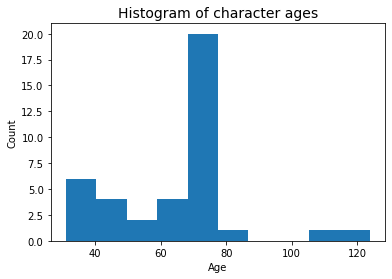

In [29]:
from neighborly.components.character import Character
from neighborly.ecs import Active


active_characters = sim.world.get_components((Active, Character))

ages = [int(character.age) for _, (_, character) in active_characters]

plt.hist(ages, bins=10)
plt.title("Histogram of character ages", fontsize=14)
plt.ylabel("Count")
plt.xlabel("Age")
plt.show()


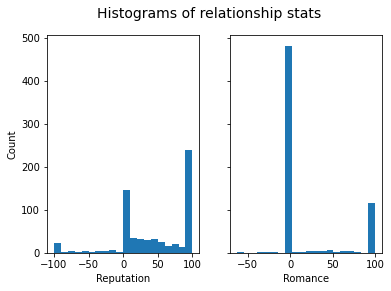

In [28]:
from neighborly.components.relationship import Relationship
from neighborly.components.stats import Stats
from neighborly.ecs import Active


active_relationships = sim.world.get_components((Active, Relationship, Stats))

reputation = [
    int(stats.get_stat("reputation").value) for _, (_, _, stats) in active_relationships
]

romance = [
    int(stats.get_stat("romance").value) for _, (_, _, stats) in active_relationships
]

fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].hist(reputation, bins=20)
axs[0].set_xlabel("Reputation")
axs[1].hist(romance, bins=20)
axs[1].set_xlabel("Romance")
axs[0].set_ylabel("Count")
fig.suptitle("Histograms of relationship stats", fontsize=14)
plt.show()


In [12]:
from neighborly.components.character import Character
from neighborly.ecs import Active
from neighborly.life_event import PersonalEventHistory


active_characters = sim.world.get_components((Active, Character, PersonalEventHistory))

personal_histories = [list(history.history) for _, (_, _, history) in active_characters]

personal_story = "\n".join(str(entry) for entry in personal_histories[6])

print(personal_story)


Drew Wickens(139) immigrated to Simple City(56).
Drew Wickens(139) started a new job as a Intern(55) at Office Building(82).
Brooks Reek(138) and Drew Wickens(139) started dating.
Drew Wickens(139) was promoted from Intern(55) to Pencil Pusher(54) at Office Building(82).
Drew Wickens(139) was fired from their role as a Pencil Pusher(54) at Office Building(82).
Drew Wickens(139) left their job as a Pencil Pusher(54) at Office Building(82) due to fired.
Drew Wickens(139) became an adult.
Drew Wickens(139) became a senior.


In [13]:
from neighborly import inspection

# inspection.list_characters(sim)
inspection.inspect(sim, 136)
# inspection.list_traits(sim)
# inspection.list_settlements(sim)
# inspection.list_districts(sim)
# inspection.list_businesses(sim)
# inspection.list_characters(sim)

# inspection.print_sim_status(sim)



Character

UID: 136
Name: Veda Peto
Status: active
Age: 73 (SENIOR)
Sex: FEMALE
Species: Human(51)

Works at: N/A
Residence: Apartment Building(98)

=== Stats ===
Stat                Value
--------------  ---------
health            8.02083
health_decay      1.25
fertility         0.79
boldness         33
stewardship     189
sociability      25
attractiveness  140
intelligence     65
reliability     175

=== Traits ===
Name                    Description
----------------------  -----------------------------------------------------------------------------------
Attracted to Women(46)  This character experiences romantic attraction primarily to women.
Skeptical(13)
Extroverted(19)         This character is outgoing and thrives in social settings.
Simple-Minded(31)       This character lacks intellectual depth and struggles with complex tasks.
Lustful(43)             This character has strong sexual desires and is often drawn to romantic encounters.

=== Skills ===
Name    Level    Descr

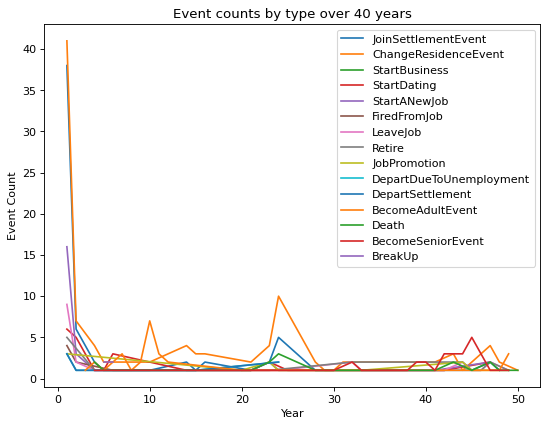

In [30]:
from neighborly.life_event import GlobalEventHistory

events = list(sim.world.resource_manager.get_resource(GlobalEventHistory))

event_bins: dict[str, dict[int, int]] = dict()

for event in events:
    event_type = event.__class__.__name__

    if event.__class__.__name__ not in event_bins:
        event_bins[event_type] = dict()

    if event.timestamp.year not in event_bins[event_type]:
        event_bins[event_type][event.timestamp.year] = 0

    event_bins[event_type][event.timestamp.year] += 1


plt.figure(figsize=(8, 6), dpi=80)

for entry, points in event_bins.items():
    plt.plot(points.keys(), points.values(), label=entry)

plt.legend(loc='upper right')
plt.ylabel("Event Count")
plt.xlabel("Year")
plt.title("Event counts by type over 40 years")
plt.show()


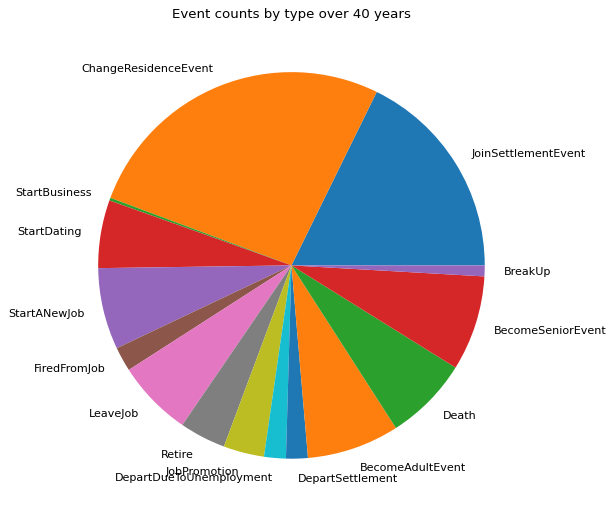

In [31]:
from neighborly.life_event import GlobalEventHistory

events = list(sim.world.resource_manager.get_resource(GlobalEventHistory))
total_events = len(events)

# Count the number of times each event was fired in the world

event_counts: dict[str, float] = {}

for event in events:
    event_type = event.__class__.__name__

    if event_type not in event_counts:
        event_counts[event_type] = 0

    event_counts[event_type] += 1


plt.figure(figsize=(8, 8), dpi=80)

plt.pie(list(event_counts.values()), labels=list(event_counts.keys()))
plt.title("Event counts by type over 40 years")
plt.show()
